# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
import random
import sys
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

### Подготовка данных

In [3]:
import cv2
from torchvision.datasets import ImageFolder
from torchvision.transforms import (Compose, Normalize, Resize, 
ToTensor, RandomHorizontalFlip, RandomRotation)

mean_img = [0.4802, 0.4481, 0.3975]
std_img = [0.2302, 0.2265, 0.2262]

train_transform = Compose(
        [Resize((224, 224), interpolation = cv2.INTER_CUBIC), 
         RandomRotation(10), 
         RandomHorizontalFlip(p=0.75),
         ToTensor(), 
         Normalize(mean_img, std_img)])

val_transform = Compose(
        [Resize((224, 224)), 
            ToTensor(), Normalize(mean_img, std_img)])

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [4]:
train_dataset = ImageFolder(
    '../input/idadlhw2data/dataset/dataset/train', 
    transform = train_transform)

val_dataset = ImageFolder(
    '../input/idadlhw2data/dataset/dataset/val', 
    transform = val_transform)

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

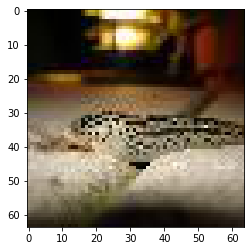

In [6]:
# Random pic
import glob
import matplotlib.pyplot as plt

file = np.random.choice(glob.glob("../input/idadlhw2data/dataset/dataset/train/*/*.jpg"))
plt.imshow(plt.imread(file));

In [7]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции, реализация модели

In [8]:
set_random_seed(2)

In [9]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cuda:0",
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    epoch_loss = total_loss / num_batches
    epoch_accuracy = (total_predictions == total_labels).mean()
    if return_losses:
        return epoch_accuracy, epoch_loss, all_losses
    else:
        return epoch_accuracy, epoch_loss


def validate(model, data_loader, criterion, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    val_loss = total_loss / num_batches
    val_accuracy = (total_predictions == total_labels).mean()
    return val_accuracy, val_loss

In [10]:
def fit(
    model,
    epochs,
    train_data_loader,
    val_data_loader,
    optimizer,
    criterion,
    scheduler,
    device="cuda:0"
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    train_accuracy = []
    val_accuracy_scores = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        epoch_accuracy, epoch_loss, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion,
            device=device)
        print('Train accuracy:', epoch_accuracy, '\n\n')
        train_accuracy.append(epoch_accuracy)
        
        # Save Train losses
        all_train_losses.append(one_epoch_train_losses)
        epoch_train_losses.append(epoch_loss)
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            val_accuracy, val_loss = validate(
                model=model,
                data_loader=val_data_loader,
                criterion=criterion
            )    
        # Save eval losses
        epoch_eval_losses.append(val_loss)
        print('Val accuracy:', val_accuracy, '\n\n')
        val_accuracy_scores.append(val_accuracy)
        
        scheduler.step(val_accuracy)
        
    #График для accuracy
    steps = list(np.arange(n_epochs) + 1)
    fig, ax = plt.subplots(figsize = (12,6))
    train_graph, = ax.plot(steps, train_accuracy,'-o', color='k', label='Train accuracy')
    val_graph, = ax.plot(steps, val_accuracy_scores, '-o', color='b', label='Val accuracy')
    ax.legend(handles=[train_graph, val_graph])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train and validation accuracy")
    plt.show()
    
    #График для Loss
    fig, ax = plt.subplots(figsize = (12,6))
    train_graph, = ax.plot(steps, epoch_train_losses,'-o', color='k', label='Train loss')
    val_graph, = ax.plot(steps, epoch_eval_losses, '-o', color='b', label='Val loss')
    ax.legend(handles=[train_graph, val_graph])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and validation Log loss")
    plt.show()

In [11]:
def predict(model, data_loader, criterion, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        predicted = model(images)
        loss = criterion(predicted, labels)
        accuracy = (predicted.argmax(1) == labels).float().mean()
        total_loss += loss.item()
        all_losses.append(loss.item())
        total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
        total_labels = np.append(total_labels, labels.cpu().detach().numpy())
        num_batches += 1
    pred_loss = total_loss / num_batches
    pred_accuracy = (total_predictions == total_labels).mean()
    print('Prediction Loss:', pred_loss, '\n',
          'Prediction Accuracy:', pred_accuracy, '\n')
    return all_losses, total_labels, total_predictions

### Обучение модели, запуски экспериментов

In [12]:
# Model, fine tuning
from torchvision.models import resnet18

model = resnet18(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)

In [13]:
#optimizer = torch.optim.Adam(model.parameters(), 1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)
n_epochs = 8
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

Train Epoch: 0


  0%|          | 0/3125 [00:00<?, ?it/s]

Train accuracy: 0.47188 


Validation Epoch: 0


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.6631 


Train Epoch: 1


  0%|          | 0/3125 [00:00<?, ?it/s]

Train accuracy: 0.67673 


Validation Epoch: 1


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.7017 


Train Epoch: 2


  0%|          | 0/3125 [00:00<?, ?it/s]

Train accuracy: 0.72884 


Validation Epoch: 2


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.7177 


Train Epoch: 3


  0%|          | 0/3125 [00:00<?, ?it/s]

Train accuracy: 0.76468 


Validation Epoch: 3


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.7181 


Train Epoch: 4


  0%|          | 0/3125 [00:00<?, ?it/s]

Train accuracy: 0.79433 


Validation Epoch: 4


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.728 


Train Epoch: 5


  0%|          | 0/3125 [00:00<?, ?it/s]

Train accuracy: 0.82169 


Validation Epoch: 5


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.7295 


Train Epoch: 6


  0%|          | 0/3125 [00:00<?, ?it/s]

Train accuracy: 0.84164 


Validation Epoch: 6


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.7286 


Train Epoch: 7


  0%|          | 0/3125 [00:00<?, ?it/s]

Train accuracy: 0.8638 


Validation Epoch: 7


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.7326 




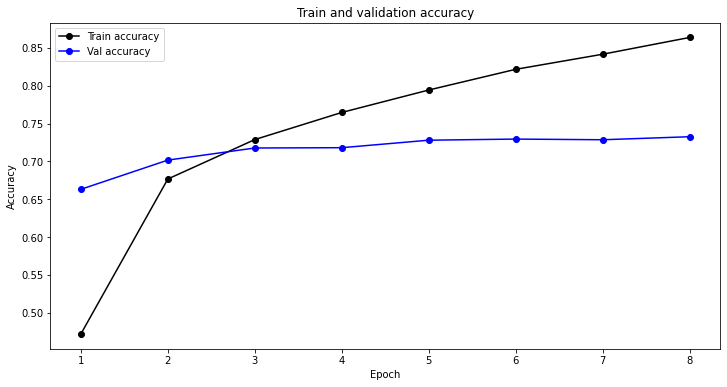

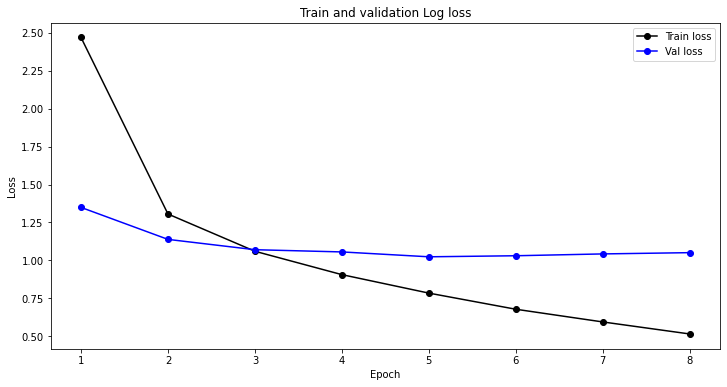

In [14]:
# Fitting the model
fit(model, n_epochs, train_dataloader, val_dataloader, optimizer, criterion, scheduler, device=device)

In [15]:
# Predictions
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)

Prediction Loss: 1.0510844307067915 
 Prediction Accuracy: 0.7326 



Простой тест на проверку правильности написанного кода

In [16]:
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

tests passed


### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [17]:
print('Полученная accuracy:', accuracy)
print("Оценка за это задание составит {} баллов".format(min(10, 10 * (accuracy - 0.5) / 0.3)))

Полученная accuracy: 0.7326
Оценка за это задание составит 7.753333333333336 баллов


### Отчёт об экспериментах 

Для этого задания я использовала предобученную модель ResNet18 и во многом следовала семинарской тетрадке (функции fit/validate, например, взяты оттуда и незначительно имзенены). 

Я не фиксировала точные значения качества модели в зависимости от изменений (типа после добавления новых аугментаций или изменений параметров) и часто орианетировалась на изменение качества на первых эпохах (для экономии времени), поэтому эксперименты опишу в общем виде (и возможно не в порядке проведения).

Сначала (при первых запусках на полном датасете с GPU) я использовала Resnet18 с заменой линейного слоя, обучала с аугемнтированным датасетом (гориз/верт отражение, вращение - мне показались более-менее "классическими") на 10 эпохах с оптимизатором Адам и без шедулера. Сделала ресайз и нормализацию, рекомендованные для ImageNet (https://pytorch.org/vision/stable/models.html). Обучение делала только на последнем слое, качество больше 0.55 не росло.

Сильно повысило качество решение дообучать все слои вместо одного - уже около 0.64-0.65 (также поменяла предпоследний слой, подсмотрела вот тут: https://github.com/tjmoon0104/Tiny-ImageNet-Classifier), но появилась новая проблема - качество на валидации выходило на плато 64-65 очень рано, уже где-то на третьей эпохе. Для предотвращения переобучения попробовала поменять аумгентации (о возможных комбинациях агугментаций, которые могут приводить к переобучению, вычитала тут: https://towardsdatascience.com/balancing-the-regularization-effect-of-data-augmentation-eb551be48374). Оставила только горизонательное отражение, качество стало лучше (поэтому увеличила еще вероятность отражения до 0.75, оставила так). Вертикальное больше не использовала (оказалось, что оно сильно мне портило каечство на валидации). Попробовала добавить к композиции вращение, поэкспериментировала с разными углами, лучше всего работал поворот на плюс-минус 10 градусов (улучшал качество на тысячные, что лучше чем ничего). Также добавила шедулер, но не уверена что он что-то улучшал (не помню). В какой-то момент я поменяла значения среднего и ст. откл. для нормализации картинок, опять же ориентируясь на этот гитхаб:  https://github.com/tjmoon0104/Tiny-ImageNet-Classifier (вроде как незначительно улучшало качество). После всех этих махинаций у меня получалось дойти до качества 0.71, но его рост на валидации был очень нестабильным.

Для того, чтобы сделать рост качества более стабильным, думала поэкспериментировать со значением learning rate в оптимизаторе, но в чате потока как раз случилось обсуждение оптимизаторов (кто-то сказал, что Адам плохо работает -???). Решила проверить SGD, и с ним мое качество поднялось до 0.73 на 8 эпохе. Сохранять лучшую модель я не научилась, поэтому просто сократила обучение до 8 эпох, мой финальный результат тут.